### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image

In [2]:
import warnings
warnings.simplefilter('ignore')

## Data analysis

In [3]:
data = pd.read_csv('/kaggle/input/itmo-ml-practitioners-comp/gt_train.csv')

In [4]:
data

,image_path,age
0,./train/58611_142976.jpg,29
1,./train/122853_63024.jpg,41
2,./train/6558_35509.jpg,16
3,./train/162357_19789.jpg,54
4,./train/170102_103246.jpg,59
...,...,...
185627,./train/112811_9368.jpg,39
185628,./train/185702_118589.jpg,97
185629,./train/262_2881.jpg,1
185630,./train/48349_91547.jpg,28


In [5]:
data["age"] = data["age"].clip(0, 99)

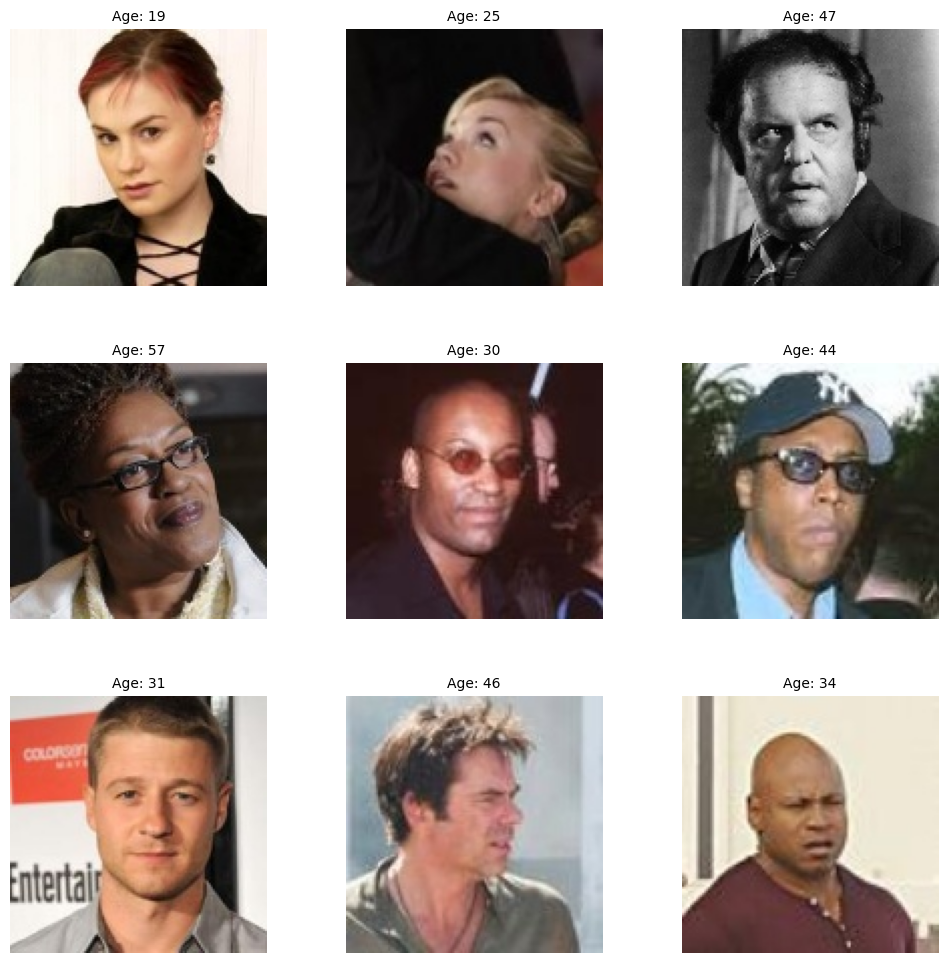

In [6]:
BASE_PATH = "/kaggle/input/itmo-ml-practitioners-comp/data/"

data["image_path"] = BASE_PATH + data["image_path"].str.lstrip('./')

random_samples = data.sample(n=9, random_state=42)
plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i, (idx, row) in enumerate(random_samples.iterrows(), 1):
    plt.subplot(3, 3, i)
    
    try:
        img = mpimg.imread(row['image_path'])
        plt.imshow(img)
        plt.title(f"Age: {row['age']}", fontsize=10)
    except FileNotFoundError:
        plt.text(0.5, 0.5, f"Not found: {os.path.basename(row['image_path'])}", ha='center', va='center')
    except Exception as e:
        plt.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
    
    plt.axis('off')

plt.show()

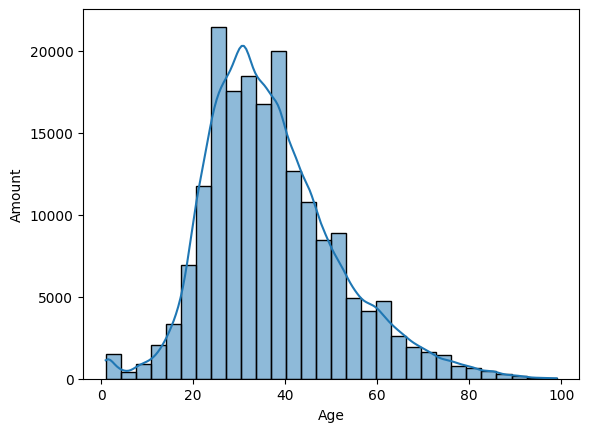

In [7]:
# Histogram of people ages distribution

sns.histplot(data.age, bins=30, kde=True, edgecolor='black')

plt.xlabel('Age')
plt.ylabel('Amount')

plt.show()

#### As we can see our distribution is skewed to the right

In [8]:
data_age_median = np.median(data.age)
print(f'Median = {data_age_median}')

data_age_avg = np.mean(data.age)
print(f'Average = {data_age_avg}')

data_age_mode = ss.mode(data.age)
print(data_age_mode)

Median = 35.0
Average = 37.15064213066712
ModeResult(mode=31, count=6790)


#### Pie-plot of ages

In [9]:
def split_data_ages(array):
    for i in ages:
        if i < 13:
            infant.append(i)
        elif i > 12 and i < 20:
            teenager.append(i)
        elif i > 19 and i < 61:
            adult.append(i)
        else:
            elder.append(i)

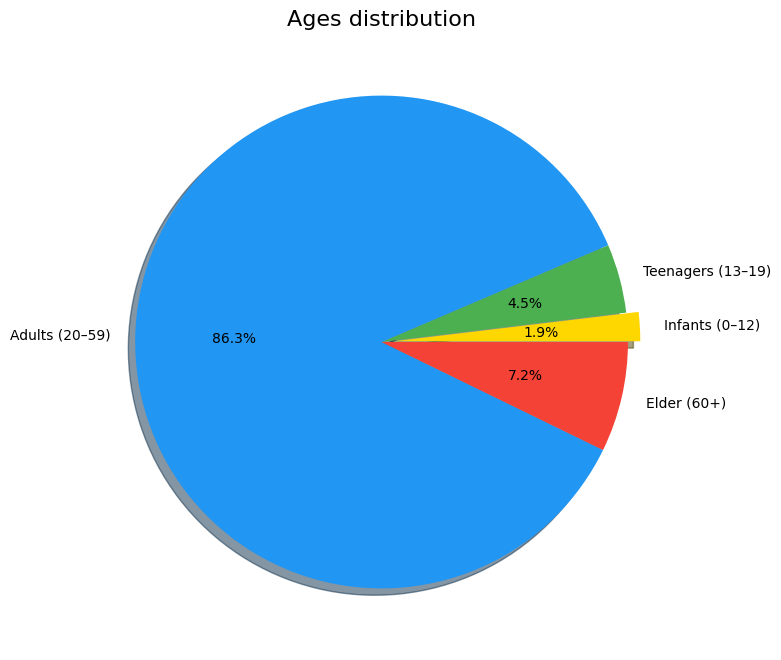

In [10]:
ages = data.age.tolist()
infant, teenager, adult, elder = [], [], [], []

split_data_ages(ages)

categories = {
    "Infants (0–12)": infant,
    "Teenagers (13–19)": teenager,
    "Adults (20–59)": adult,
    "Elder (60+)": elder
}

counts = [len(cat) for cat in categories.values()]
labels = list(categories.keys())

plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    colors=['#FFD700', '#4CAF50', '#2196F3', '#F44336'],
    explode=(0.05, 0, 0, 0),
    shadow=True
)
plt.title("Ages distribution", fontsize=16)
plt.show()

## Model evaluation

In [11]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, stratify=pd.cut(data["age"], bins=10))

In [12]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
class AgeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        age = self.data.iloc[idx]["age"]
        
        if not (0 <= age < 100):
            raise ValueError(f"Некорректный возраст: {age}. Допустимый диапазон: 0-99.")
        
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
            
        return img, age

In [14]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
train_ds = AgeDataset(train_data, train_transform)
val_ds = AgeDataset(val_data, val_transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=4)

In [16]:
class AgeModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, weight_decay=1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
        self.backbone.fc = nn.Linear(2048, 100)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        
        pred_ages = torch.softmax(logits, dim=1) @ torch.arange(0, 100, device=self.device).float()
        mae = torch.abs(pred_ages - y.float()).mean()
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mae", mae, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            patience=3,
            factor=0.1,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [17]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_mae",
    mode="min",
    save_top_k=1,
    dirpath="checkpoints/",
    filename="best_model",
)

early_stopping = EarlyStopping(
    monitor="val_mae",
    patience=10,
    mode="min",
)

In [18]:
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback, early_stopping],
)

In [20]:
model = AgeModel(learning_rate=1e-4, weight_decay=1e-5)
trainer.fit(model, train_loader, val_loader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
best_model = AgeModel.load_from_checkpoint("checkpoints/best_model.ckpt")

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


## Check predictions

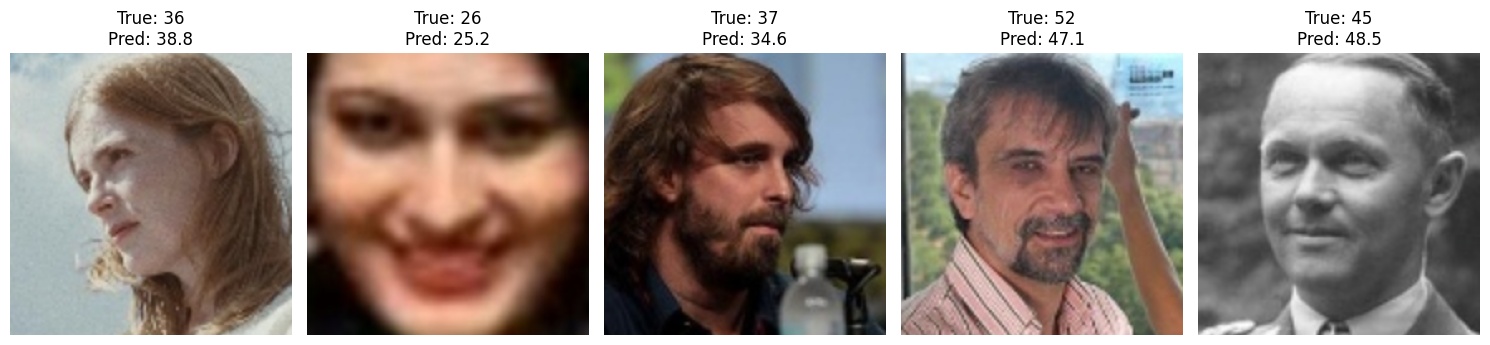

In [28]:
def plot_predictions(model, dataset, num_samples=5):
    model.eval()
    device = next(model.parameters()).device
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img, true_age = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = model(img_tensor)
            pred_age = torch.softmax(logits, dim=1) @ torch.arange(0, 100, device=device).float()
        
        img_np = img.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_np)
        plt.title(f"True: {true_age}\nPred: {pred_age.item():.1f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_predictions(best_model, val_ds, num_samples=5)

In [29]:
def compute_mae(model, dataloader):
    model.eval()
    total_mae = 0.0
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred_ages = torch.softmax(logits, dim=1) @ torch.arange(0, 100, device=device).float()
            total_mae += torch.abs(pred_ages - y.float()).sum().item()
    
    return total_mae / len(dataloader.dataset)

In [30]:
val_mae = compute_mae(best_model, val_loader)
print(f"Validation MAE: {val_mae:.2f} years")

Validation MAE: 6.92 years


## Test evaluation

In [42]:
test_images = [f for f in os.listdir("/kaggle/input/itmo-ml-practitioners-comp/data/test") if f.endswith(('.jpg', '.png', '.jpeg'))]

In [43]:
test_df = pd.DataFrame({"image_path": [os.path.join("/kaggle/input/itmo-ml-practitioners-comp/data/test", img) for img in test_images]})

In [44]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [45]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [46]:
test_ds = TestDataset(test_df, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)

In [47]:
def predict_age(model, img_tensor):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        logits = model(img_tensor.to(device))
        flipped_logits = model(torch.flip(img_tensor.to(device), dims=[3]))
        avg_logits = (logits + flipped_logits) / 2
        pred_age = torch.softmax(avg_logits, dim=1) @ torch.arange(0, 100, device=device).float()
    
    return pred_age.cpu().numpy()

In [48]:
all_preds = []
for batch in test_loader:
    preds = predict_age(best_model, batch)
    all_preds.extend(preds.squeeze())

In [49]:
test_df["age"] = [round(pred) for pred in all_preds]

In [50]:
test_df.head()

,image_path,age
0,/kaggle/input/itmo-ml-practitioners-comp/data/...,60
1,/kaggle/input/itmo-ml-practitioners-comp/data/...,57
2,/kaggle/input/itmo-ml-practitioners-comp/data/...,36
3,/kaggle/input/itmo-ml-practitioners-comp/data/...,26
4,/kaggle/input/itmo-ml-practitioners-comp/data/...,35


In [51]:
len(test_df)

47568

In [52]:
submission_df = test_df[["image_path", "age"]]
submission_df.to_csv("submission.csv", index=False)

In [55]:
def shorten_path(full_path):
    filename = os.path.basename(full_path)
    return f"./test/{filename}"

In [56]:
submission_df["image_path"] = submission_df["image_path"].apply(shorten_path)

In [57]:
submission_df

,image_path,age
0,./test/39671_18235.jpg,60
1,./test/46958_35396.jpg,57
2,./test/39883_21520.jpg,36
3,./test/12726_35043.jpg,26
4,./test/26264_24105.jpg,35
...,...,...
47563,./test/21695_13863.jpg,34
47564,./test/22249_38965.jpg,37
47565,./test/32366_31455.jpg,39
47566,./test/16201_8691.jpg,42


In [58]:
submission_df.to_csv("submission_short.csv", index=False)